# Movilidad y características de comunas


In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
matplotlib.style.use("fivethirtyeight")

## Load Data

In [3]:
prod_33 = "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto33/"
mobility = pd.read_csv(prod_33 + "IndiceDeMovilidad.csv")
mobility["Fecha"] = pd.to_datetime(mobility.Fecha, format="%Y-%m-%d")
mobility['lagged_Fecha'] = mobility['Fecha'] - pd.Timedelta("8d")

print("Fecha min: ", mobility.Fecha.min(), " fecha max: ", mobility.Fecha.max())
mobility.columns

Fecha min:  2020-02-26 00:00:00  fecha max:  2020-05-17 00:00:00


Index(['Region', 'Codigo region', 'Comuna', 'Codigo comuna', 'Superficie_km2',
       'Poblacion', 'IM_interno', 'IM_externo', 'IM', 'Fecha', 'lagged_Fecha'],
      dtype='object')

Text(0.5, 1.0, 'Las Condes: Movilidad Interna y Externa')

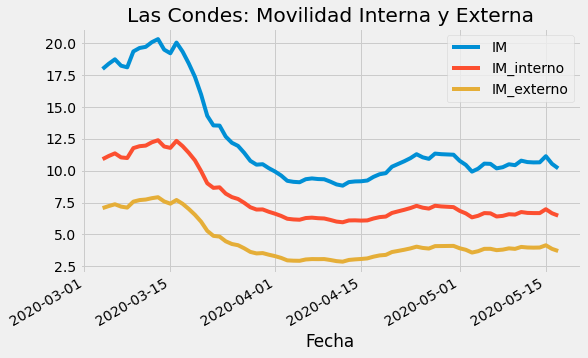

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
(mobility[mobility['Comuna'] == 'Las Condes'][['Comuna', 'Fecha', 'IM_interno',
                                            'IM_externo', 'IM']]
.set_index('Fecha')[['IM', 'IM_interno', 'IM_externo']]
 .rolling(8).mean().plot(ax=ax))
ax.set_title("Las Condes: Movilidad Interna y Externa")

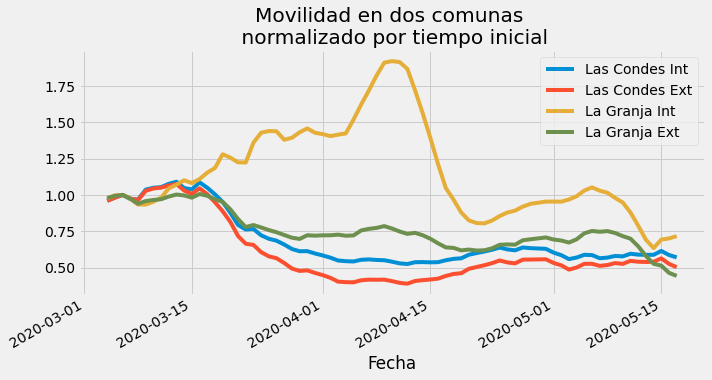

In [20]:
def comparar_dos_comunas(nom_comuna1: str, nom_comuna2: str):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    comuna1 = (mobility[mobility['Comuna'] == nom_comuna1].set_index('Fecha')
     ['IM_interno'].rolling(8).mean())

    (comuna1 / comuna1[9]).plot(ax=ax, label=f"{nom_comuna1} Int")

    comuna1 = (mobility[mobility['Comuna'] == nom_comuna1].set_index('Fecha')
     ['IM_externo'].rolling(8).mean())
    (comuna1 / comuna1[9]).plot(ax=ax, label=f"{nom_comuna1} Ext")

    comuna2 = (mobility[mobility['Comuna'] == nom_comuna2].set_index('Fecha')
     ['IM_interno'].rolling(8).mean())
    (comuna2 / comuna2[9]).plot(ax=ax, label=f"{nom_comuna2} Int")

    comuna2 = (mobility[mobility['Comuna'] == nom_comuna2].set_index('Fecha')
     ['IM_externo'].rolling(8).mean())
    (comuna2 / comuna2[9]).plot(ax=ax, label=f"{nom_comuna2} Ext")
    ax.legend()
    ax.set_title("Movilidad en dos comunas \n normalizado por tiempo inicial");
    
    return fig, ax

comparar_dos_comunas('Las Condes', 'La Granja');

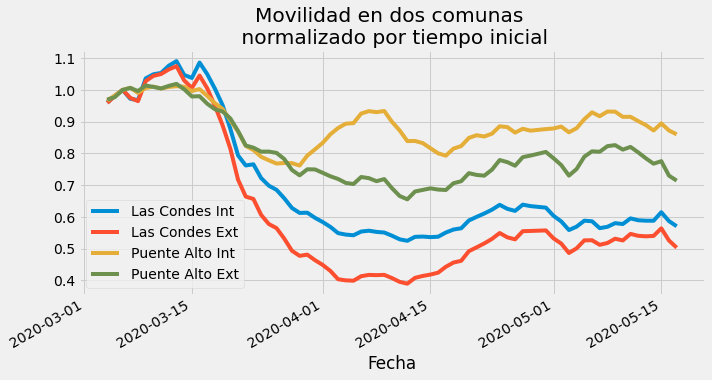

In [21]:
comparar_dos_comunas('Las Condes', 'Puente Alto');